In [1]:
%cd ..
%reload_ext autoreload
%autoreload 2

/home/tobias/tum-adlr-ws20-9


In [2]:
#importing libraries
import numpy as np
import pyspiel
import math
import matplotlib.pyplot as plt
import torch
import copy
import trueskill
from statistics import mean
from scipy.stats import entropy
from torch.distributions import Categorical
from pathlib import Path

from open_spiel.python.algorithms.alpha_zero import model as model_lib
from open_spiel.python.algorithms.alpha_zero import evaluator as evaluator_lib
from open_spiel.python.algorithms import mcts

from alpha_one.metrics import MatchOutcome, EloRatingSystem, TrueSkillRatingSystem

First attempt at imitating the training procedure of AlphaZero. It is comprised of 3 main parts:  
 1. Generating training data using MCTS and the current best model
 2. Updating weights of a challenger model using the generated training data
 3. Evaluating the challenger model against the current best model. If it can beat it by a significant margin, the challenger model will from then on be used for generating the training data

# 1. Parameters

In [3]:
model_saves_path = '../model_saves/connect_four'

UCT_C = math.sqrt(2)
max_mcts_simulations = 100
n_selfplay_simulations = 15            # How many play throughs should be generated by best model for training. (Training set size)
n_train_steps = 50                    # After how many gradient updates the new model tries to beat the current best
n_iterations = 100                     # How often the whole procedure is repeated. Also corresponds to the number of evaluations
n_evaluations = 20                     # How many games should be played to measure which model is better
batch_size = 256
evaluation_strategy = 'mcts'           # 'best_response'
n_most_recent_train_samples = 5000     # Among which training samples to choose to train current model

In [4]:
nn_width = 128
nn_depth = 4
weight_decay = 1e-5
learning_rate = 5e-4

# 2. Functions

In [5]:
# build the tensorflow model
model_type = 'mlp'
def build_model(game):
    return model_lib.Model.build_model(
      model_type, game.observation_tensor_shape(), game.num_distinct_actions(),
      nn_width=nn_width, nn_depth=nn_depth, weight_decay=weight_decay, learning_rate=learning_rate, path=model_saves_path)

## 2.1 Main methods

In [6]:
def executeEpisode(game, temperature):

    rng = np.random.RandomState(42)
    train_inputs = []
    state = game.new_initial_state()
    
    mcts_bot = mcts.MCTSBot(
      game,
      UCT_C,
      max_simulations=max_mcts_simulations,
      solve=False,
      random_state=rng,
      evaluator=evaluator_lib.AlphaZeroEvaluator(game, model_current_best))
    
    observations = []
    action_masks = []
    policies = []
        
    while not state.is_terminal():
        root = mcts_bot.mcts_search(state)
        policy = np.zeros(game.num_distinct_actions())
        
        for c in root.children:
            policy[c.action] = c.explore_count
        policy = policy ** (1 / temperature)
        policy /= policy.sum()
        action = np.random.choice(len(policy), p=policy)
        obs = state.observation_tensor()
        act_mask = state.legal_actions_mask()
        
        observations.append(obs)
        action_masks.append(act_mask)
        policies.append(policy)
    
        # train_inputs.append(model_lib.TrainInput(obs, act_mask, policy, value=1))              
   
        state.apply_action(action) 
    
    final_game_reward = state.player_reward(0)
    train_inputs = [model_lib.TrainInput(obs, act_mask, policy, value=final_game_reward) for obs, act_mask, policy in zip(observations, action_masks, policies)]
    
    return train_inputs

In [7]:
def generate_training_data():
    train_inputs = []
    for _ in range(n_selfplay_simulations):
        train_inputs.extend(executeEpisode(game, 1))
    print(f'  - Generated {len(train_inputs)} additional training samples')
    return train_inputs

In [8]:
def train_model(train_inputs):
    losses = []   
    for _ in range(n_train_steps): 
        train_set_idx = np.random.choice(range(len(train_inputs)), batch_size)
        loss = model.update([train_inputs[i] for i in train_set_idx])
        losses.append(loss)
    print(f'  - Training: {mean_total_loss(losses[:int(len(losses)/4)]):.2f} \
                -> {mean_total_loss(losses[int(len(losses)/4):int(2 * len(losses)/4)]):.2f} \
                -> {mean_total_loss(losses[int(2 * len(losses)/4):int(3 * len(losses)/4)]):.2f} \
                -> {mean_total_loss(losses[int(3 * len(losses)/4):]):.2f}')
    

In [9]:
def evaluate_challenger_model(model_challenger, model_current_best):
    rng = np.random.RandomState(42)
    
    if evaluation_strategy == 'mcts':
    
        mcts_bot_best_model = mcts.MCTSBot(
          game,
          UCT_C,
          max_simulations=max_mcts_simulations,
          solve=False,
          random_state=rng,
          evaluator=evaluator_lib.AlphaZeroEvaluator(game, model_current_best))

        mcts_bot_challenger = mcts.MCTSBot(
          game,
          UCT_C,
          max_simulations=100,
          solve=False,
          random_state=rng,
          evaluator=evaluator_lib.AlphaZeroEvaluator(game, model_challenger))
    
    challenger_results = []
    for _ in range(n_evaluations):
        model_challenger_player = np.random.choice([0, 1]) # ensure that each model will play as each player
        state = game.new_initial_state()
        while not state.is_terminal():
            # model_current_turn = model if state.current_player() == model_challenger_player else model_current_best
            
            if evaluation_strategy == 'mcts':
                mcts_bot_current_turn = mcts_bot_challenger if state.current_player() == model_challenger_player else mcts_bot_best_model
                root = mcts_bot_current_turn.mcts_search(state)
                policy = compute_mcts_policy(root, 0) # Always choose action with highest visit count
            else:
                pass
                # obs = state.observation_tensor()
                # act_mask = state.legal_actions_mask()
                # value, policy = model_current_turn.inference([obs], [act_mask])
                # TODO: implement
            action = policy.argmax(-1)
            state.apply_action(action)
        challenger_reward = state.player_reward(model_challenger_player)
        if challenger_reward == 1:
            match_outcomes.append(MatchOutcome.win(player_id_challenger, player_id_current_best))
        else:
            match_outcomes.append(MatchOutcome.defeat(player_id_challenger, player_id_current_best))
        challenger_results.append(challenger_reward)
    
    n_challenger_wins = (np.array(challenger_results) == 1).sum()
    challenger_win_rate = n_challenger_wins / n_evaluations
    print(f'  - Challenger won {n_challenger_wins}/{n_evaluations} games ({challenger_win_rate:.2%} win rate)')
    return challenger_win_rate


## 2.2 Helper methods

In [10]:
def compute_mcts_policy(root, temperature):
    policy = np.zeros(game.num_distinct_actions())
        
    for c in root.children:
        policy[c.action] = c.explore_count
    if temperature == 0 or temperature is None:
        # Create probability distribution with peak at most likely action
        new_policy = np.zeros(game.num_distinct_actions())
        new_policy[policy.argmax(-1)] = 1
        policy = new_policy
    else:
        policy = policy ** (1 / temperature)
        policy /= policy.sum()
    return policy

In [11]:
def mean_total_loss(losses):
    return mean([loss.total for loss in losses])

def load_model(iteration):
    new_model = build_model(game)
    new_model.load_checkpoint(f"{model._path}/checkpoint-{iteration}")
    return new_model

def copy_and_create_checkpoint(iteration):
    # Generate checkpoint
    output_path = Path(model_saves_path)
    output_path.mkdir(parents=True, exist_ok=True)
    model.save_checkpoint(iteration)
    return load_model(iteration)

# 3. Training

In [15]:
game = pyspiel.load_game("connect_four")
model = build_model(game)
print("Num variables:", model.num_trainable_variables)
model.print_trainable_variables()
model_current_best = copy_and_create_checkpoint(0)

Num variables: 99848
torso_0_dense/kernel:0: (126, 128)
torso_0_dense/bias:0: (128,)
torso_1_dense/kernel:0: (128, 128)
torso_1_dense/bias:0: (128,)
torso_2_dense/kernel:0: (128, 128)
torso_2_dense/bias:0: (128,)
torso_3_dense/kernel:0: (128, 128)
torso_3_dense/bias:0: (128,)
policy_dense/kernel:0: (128, 128)
policy_dense/bias:0: (128,)
policy/kernel:0: (128, 7)
policy/bias:0: (7,)
value_dense/kernel:0: (128, 128)
value_dense/bias:0: (128,)
value/kernel:0: (128, 1)
value/bias:0: (1,)
INFO:tensorflow:Restoring parameters from ../model_saves/connect_four/checkpoint-0


In [16]:
# Evaluation setup
match_outcomes = []
rating_system_true_skill = TrueSkillRatingSystem()
rating_system_elo = EloRatingSystem(40)
player_id_current_best = 0
player_id_challenger = 1

In [ ]:
train_inputs = []
for iteration in range(n_iterations):
    print(f"Iteration {iteration}")
    # 1 Generate training data with current best model
    train_inputs.extend(generate_training_data())
    train_inputs = train_inputs[-n_most_recent_train_samples:]
    
    # 2 Repeatedly sample from training set and update weights on current model
    train_model(train_inputs)
    
    # 3 Evaluate trained model against current best model
    challenger_win_rate = evaluate_challenger_model(model, model_current_best)
    
    # Update True Skill ratings
    current_ratings = rating_system_true_skill.calculate_ratings(match_outcomes)
    elo_ratings = rating_system_elo.calculate_ratings(match_outcomes)
    print(f"  - True Skill ratings:")
    print(f"     current best: {current_ratings[player_id_current_best]}")
    print(f"     challenger: {current_ratings[player_id_challenger]}")
    print(f"  - Elo ratings:")
    print(f"     current best: {elo_ratings[player_id_current_best]}")
    print(f"     challenger: {elo_ratings[player_id_challenger]}")
    match_outcomes = []
    player_id_challenger += 1
    
    if challenger_win_rate > 0.55:
        print(f"  - Model at iteration {iteration} supersedes previous model ({challenger_win_rate:.2%} win rate)")
        model_current_best = copy_and_create_checkpoint(iteration)
        
        player_id_current_best = player_id_challenger - 1
    
    

Iteration 0
  - Generated 224 additional training samples
  - Training: 2.83                 -> 2.59                 -> 2.36                 -> 2.21
  - Challenger won 4/20 games (20.00% win rate)
  - True Skill ratings:
     current best: trueskill.Rating(mu=27.482, sigma=2.268)
     challenger: trueskill.Rating(mu=22.518, sigma=2.268)
  - Elo ratings:
     current best: 89.75712615155174
     challenger: -89.75712615155174
Iteration 1
  - Generated 271 additional training samples
  - Training: 2.61                 -> 2.35                 -> 2.24                 -> 2.16
  - Challenger won 5/20 games (25.00% win rate)
  - True Skill ratings:
     current best: trueskill.Rating(mu=28.759, sigma=1.512)
     challenger: trueskill.Rating(mu=23.027, sigma=1.845)
  - Elo ratings:
     current best: 188.88492335646856
     challenger: 80.06917386502363
Iteration 2
  - Generated 259 additional training samples
  - Training: 2.44                 -> 2.33                 -> 2.26                 -

# Visualizations

In [70]:
def extract_histories(train_inputs):
    histories = []
    current_history = []
    for sample in train_inputs:
        n_pieces_played = (1 - np.array(sample.observation).reshape(3, 6, 7)[2]).sum()
        if n_pieces_played == 0 and current_history:
            histories.append(current_history)
            current_history = []
        current_history.append(sample)
    if n_pieces_played == 0 and current_history:
        histories.append(current_history)
    return histories

In [78]:
plot_data = []
for history in extract_histories(train_inputs):
    n_samples = len(history)
    for i, sample in enumerate(history):
        plot_data.append((i / n_samples, entropy(sample.policy)))

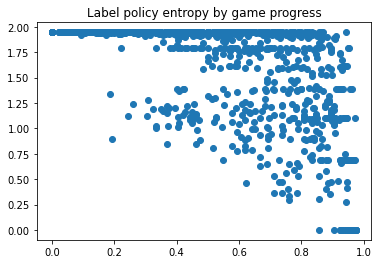

In [79]:
history_progresses, entropies = zip(*plot_data)
plt.figure()
plt.title("Label policy entropy by game progress")
plt.scatter(history_progresses, entropies)
plt.show()

In [63]:
entropy_by_pieces = []
for sample in train_inputs:
    n_pieces_played = (1 - np.array(sample.observation).reshape(3, 6, 7)[2]).sum()
    entropy_by_pieces.append((n_pieces_played, entropy(sample.policy)))

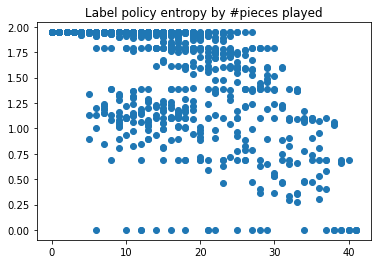

In [75]:
n_pieces, entropies = zip(*entropy_by_pieces)
plt.figure()
plt.title("Label policy entropy by #pieces played")
plt.scatter(n_pieces, entropies)
plt.show()

# 4. Investigation of specific game scenarios

In [24]:
state = game.new_initial_state()
state.apply_action(3)
state.apply_action(3)
state.apply_action(4)
print(state.observation_string())

.......
.......
.......
.......
...o...
...xx..



In [25]:
model.inference([state.observation_tensor()], [state.legal_actions_mask()])

[array([[-0.93504727]], dtype=float32),
 array([[0.13526161, 0.09571104, 0.2229089 , 0.22437674, 0.08570125,
         0.1612992 , 0.07474129]], dtype=float32)]

In [26]:
model_current_best.inference([state.observation_tensor()], [state.legal_actions_mask()])

[array([[-0.9561274]], dtype=float32),
 array([[0.18993177, 0.11807724, 0.19278333, 0.16555892, 0.10689081,
         0.1458753 , 0.08088259]], dtype=float32)]

In [20]:
model_loaded = load_model(0)
model_loaded.inference([state.observation_tensor()], [state.legal_actions_mask()])

INFO:tensorflow:Restoring parameters from ../../model_saves/connect_four/checkpoint-0


[array([[-0.05155722]], dtype=float32),
 array([[0.13417855, 0.14319465, 0.13845864, 0.13116197, 0.16058978,
         0.13832514, 0.15409122]], dtype=float32)]

In [31]:
evaluate_challenger_model(model_current_best, model_loaded)

  - Challenger won 9/20 games (45.00% win rate)


0.45

In [ ]:
mcts_bot_challenger = mcts.MCTSBot(
          game,
          UCT_C,
          max_simulations=100,
          solve=False,
          random_state=np.random.RandomState(42),
          evaluator=evaluator_lib.AlphaZeroEvaluator(game, model_loaded))
root = mcts_bot_challenger.mcts_search(state)
policy = [c.explore_count / 100 for c in sorted(root.children, key=lambda x: x.action)]
policy